In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from constants import CLASSES
from pathlib import Path
from utils import train_net

In [3]:
# for colab
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/deadskull7/fer2013/download" -O fer2013.zip
!python unpack_data.py

--2020-04-12 12:16:32--  https://www.kaggle.com/deadskull7/fer2013/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586952992&Signature=TPXhRJZLvmyJ3xT%2FglmFmqWx%2Fd8ctPhqKXWKjfQYyMT0StTZx7ODQ%2FQYyR2L2URtV69O5XGob6bsSKNlpmUi3fqb3x4H3CCVgcXiPmikDJ6YTFR5F9wpp6%2FQsSfPC85GRUE8o835no0Yc6xcz1vfikW%2FoJkzPqV98YMqlIQ7VsBdA0nfhcpSRNcz3519%2BpkzLJitfPD6T%2F3ZngSjw91%2BvTwJjVpbQx5RXwzsytYV0sWE0Laz4a7%2BtcBllSrto7y0Jhysyd5Mn0Le3VMxhQg81WjnAemp6wPZXNzslGdbTAx4n1%2FlOI5HomPIj0LmNDDyIpEOAW70p1w8UxWHHoMplA%3D%3D&response-content-disposition=attachment%3B+filename%3Dfer2013.zip [following]
--2020-04-12 12:16:33--  https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip?Googl

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

transform_augment = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.Grayscale(),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.2),
     transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [0]:
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform_augment)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [0]:
valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
net = torchvision.models.resnet18()
net.conv1 = nn.Conv2d(1, 64, 7, 2, padding=3, padding_mode='zeros', bias=False)
net.fc = nn.Linear(in_features=512, out_features=len(CLASSES), bias=True)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=0.001)

[1,   449] train_loss: 1.580, val_loss: 1.360, val_acc: 0.481
[2,   449] train_loss: 1.268, val_loss: 1.356, val_acc: 0.481
[3,   449] train_loss: 1.176, val_loss: 1.281, val_acc: 0.524
[4,   449] train_loss: 1.111, val_loss: 1.161, val_acc: 0.544
[5,   449] train_loss: 1.069, val_loss: 1.082, val_acc: 0.589
[6,   449] train_loss: 1.036, val_loss: 1.080, val_acc: 0.591
[7,   449] train_loss: 1.009, val_loss: 1.052, val_acc: 0.605
[8,   449] train_loss: 0.978, val_loss: 1.049, val_acc: 0.598
[9,   449] train_loss: 0.959, val_loss: 1.020, val_acc: 0.614
[10,   449] train_loss: 0.935, val_loss: 0.996, val_acc: 0.624
[11,   449] train_loss: 0.918, val_loss: 1.009, val_acc: 0.627
[12,   449] train_loss: 0.897, val_loss: 1.013, val_acc: 0.625
[13,   449] train_loss: 0.883, val_loss: 0.999, val_acc: 0.633
[14,   449] train_loss: 0.867, val_loss: 0.974, val_acc: 0.648
[15,   449] train_loss: 0.848, val_loss: 0.982, val_acc: 0.640
[16,   449] train_loss: 0.824, val_loss: 0.938, val_acc: 0.652
[

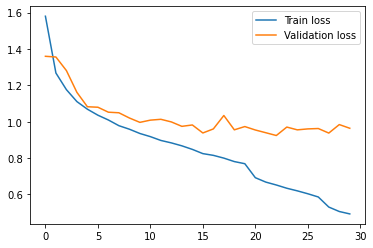

In [8]:
train_net(net, trainloader, valloader, criterion, optimizer, device, 
          num_epochs=30, lr_scheduler=scheduler, eval_period=len(trainloader))

In [0]:
Path('weights').mkdir(exist_ok=True)
PATH = 'weights/resnet18.pth'
torch.save(net.state_dict(), PATH)

### Evaluating

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
net = torchvision.models.resnet18()
net.conv1 = nn.Conv2d(1, 64, 7, 2, padding=3, padding_mode='zeros', bias=False)
net.fc = nn.Linear(in_features=512, out_features=len(CLASSES), bias=True)

In [12]:
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 68 %


In [15]:
class_correct = [0. for i in range(len(CLASSES))]
class_total = [0. for i in range(len(CLASSES))]
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).reshape(1, -1)
        for i in range(c.size()[1]):
            label = labels[i].item()
            class_correct[label] += c[0, i].item()
            class_total[label] += 1


for i in range(len(CLASSES)):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of angry : 63 %
Accuracy of disgust : 62 %
Accuracy of  fear : 52 %
Accuracy of happy : 86 %
Accuracy of   sad : 52 %
Accuracy of surprise : 84 %
Accuracy of neutral : 65 %
